# TP3 : Lazy training


Observing the lazy training regime with different models

With inspiration from

https://rajatvd.github.io/NTK/

In [1]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [96]:
### Exectutes the script tp3_utils.py which contains code from last time
## Go take a quick look at the functions implemented there

from tp3_utils import * 

# %load_ext autoreload
# %autoreload 2

## The data

We continue with last week's toy problem of 1 dimensional regression

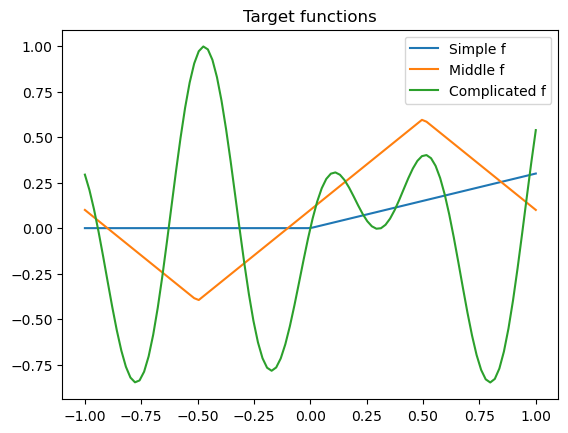

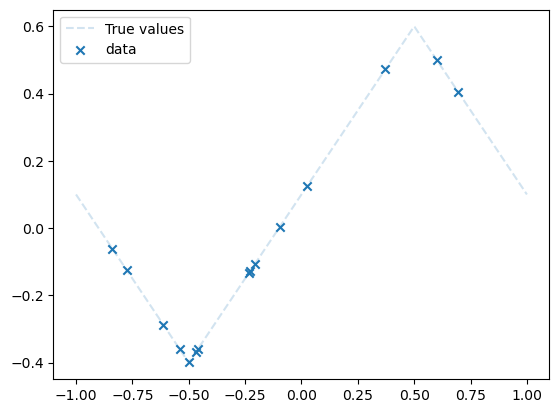

In [99]:
xs = np.linspace(-1, 1, 100)
plt.plot(xs, simple_f(xs), label='Simple f')
plt.plot(xs, middle_f(xs), label='Middle f')
plt.plot(xs, complex_f(xs), label='Complicated f')
plt.title('Target functions')
plt.legend()
plt.show()

dataset = Data(n=15,
                xmin=-1,
                xmax=1,
                noise_level=0,
                type='middle')

plot_data(dataset)
plt.legend()
plt.show()

## The training function

Write the training function

In [4]:
def train(net, 
          dataset, 
          N_steps=1, 
          batch_size=30, 
          lr=0.01, 
          save_weights_every=100):
    
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    weights = []

    for i in range(N_steps): 
        inputs, labels= dataset.next_batch(batch_size)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())

        if i % save_weights_every == 0 and (save_weights_every > 0):
            with torch.no_grad():
                weights.append(net.save_weights())

    return losses

In [ ]:
def train(net, 
          dataset, 
          N_steps=1, 
          batch_size=30, 
          lr=0.01, 
          save_weights_every=100):
    
    # YOUR CODE HERE

    losses = []
    weights = []

    for i in range(N_steps): 
        # YOUR CODE HERE

        losses.append(loss.detach().numpy())

        if i % save_weights_every == 0 and (save_weights_every > 0):
            with torch.no_grad():
                weights.append(net.save_weights())

    return losses

## Test your training

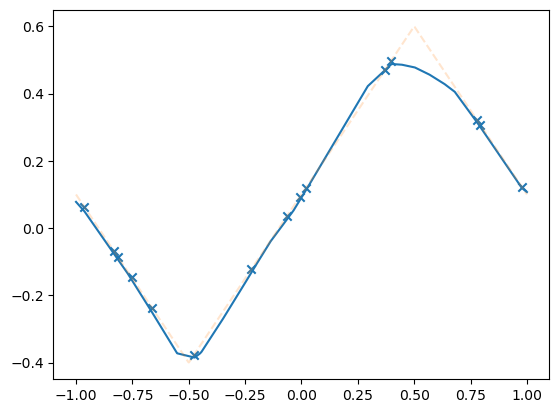

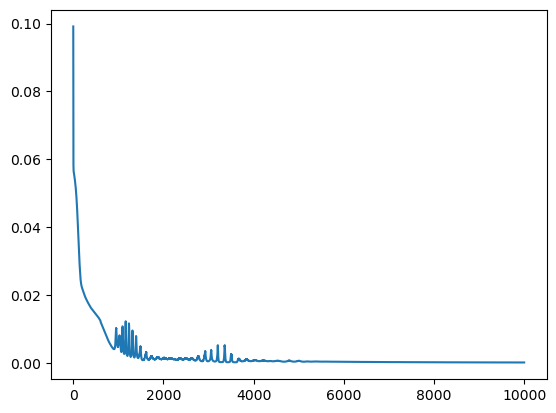

In [5]:
model = MLPdeep(hidden_dim=10)
losses = train(model, 
                dataset, 
                N_steps=10000, 
                batch_size=15, 
                lr=.1, 
                save_weights_every=1,
                )

plot_net(model)
plot_data(dataset)
plt.show()

plt.plot(losses)
plt.show()

# A linear model

We define a family of linear models with sinusoidal features. 
The feature map is 

$$
    \phi(x) = ( \cos(2 \pi x) , \sin(2 \pi x), \cos(4 \pi x) , \sin(4 \pi x), \dots ,  \cos(2k \pi x) , \sin(2k \pi x))
$$
where $k$ is feature_dim / 2. 

In [202]:
class LinSin(nn.Module): 
    """
        A linear model with sinusoidal features. Assumes feature_dim is even.
    """
    def __init__(self, feature_dim): 
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
            Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        r = 2 * np.pi * torch.arange(int(self.feature_dim / 2)) * x
        return torch.concatenate([torch.sin(r), torch.cos(r)], axis=1)

    def save_weights(self): 
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x): 
        return self.lout(self.phi(x))

In [ ]:
class LinSin(nn.Module): 
    """
        A linear model with sinusoidal features
    """
    def __init__(self, feature_dim): 
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
            Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        # YOUR CODE HERE
        pass

    def save_weights(self): 
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x): 
        # YOUR CODE HERE
        pass

Test the linear model

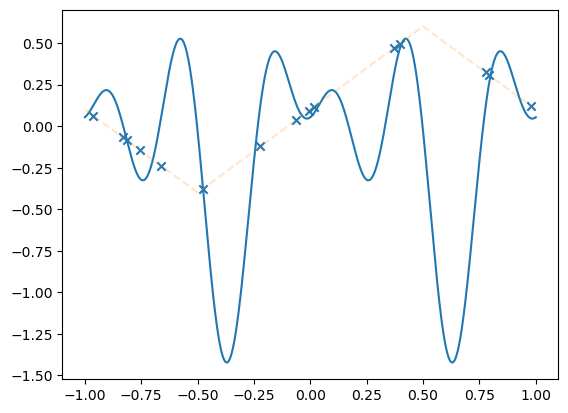

Text(0.5, 1.0, 'Relative weight movement of last layer')

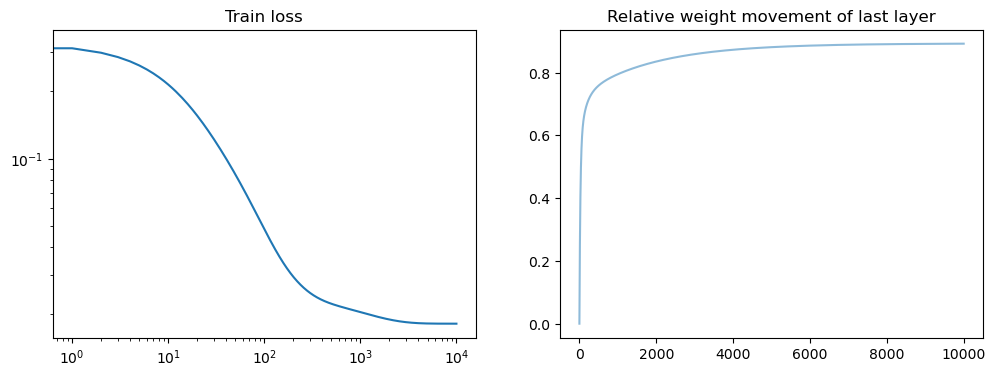

In [7]:
model = LinSin(feature_dim=8)
losses = train(model, 
                dataset, 
                N_steps=10000, 
                batch_size=15, 
                lr=.01, 
                save_weights_every=1,
                )

plot_net(model)
plot_data(dataset)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title('Train loss')

all_weights1 = np.array(model.weight_history)
weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])
axs[1].plot(weight_evol, alpha=.5) 
axs[1].set_title('Relative weight movement of last layer')

**Question**: what do the plots mean?

Let us now repeat the code above with a large feature dimension. What you do observe? 

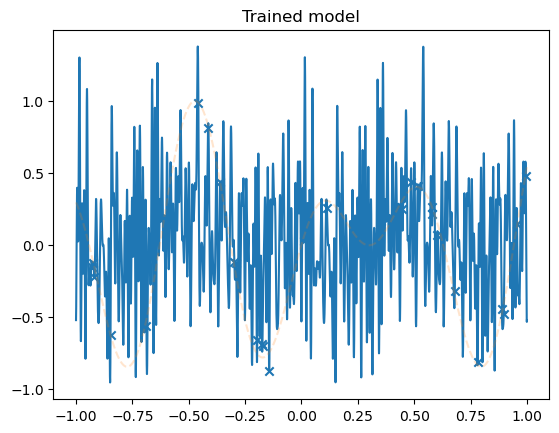

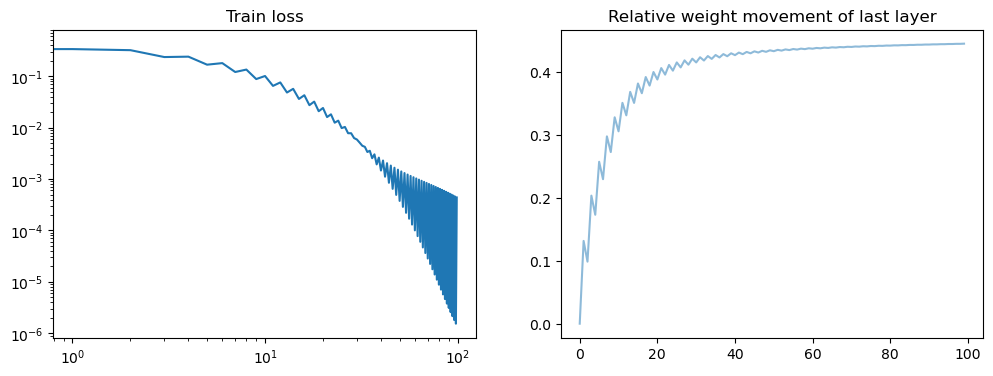

In [98]:
model = LinSin(feature_dim=200)
losses = train(model, 
                dataset, 
                N_steps=100, 
                batch_size=15, 
                lr=.01, 
                save_weights_every=1,
                )

plot_net(model)
plot_data(dataset)
plt.title('Trained model')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title('Train loss')

all_weights1 = np.array(model.weight_history)
weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])
axs[1].plot(weight_evol, alpha=.5) 
axs[1].set_title('Relative weight movement of last layer')

plt.show()

## Robustness of fast convergence for linear models

Run 10 instances of the linear model with different initializations. 

Are there significant differences between the models? 

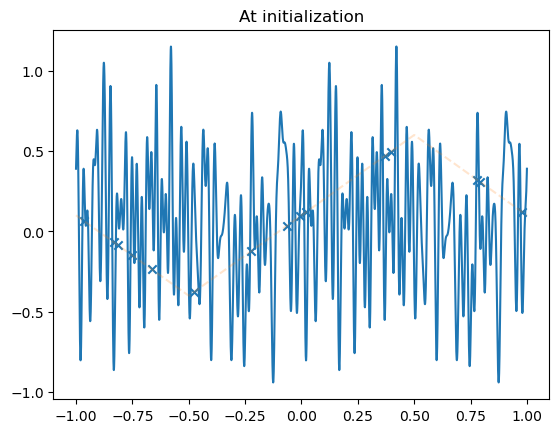

In [51]:
model_list = []
N_models = 1
for _ in range(N_models): 
    model = LinSin(feature_dim=100)
    model_list.append(model)
    plot_net(model)

plot_data(dataset)
plt.title('At initialization')

all_losses = [[] for _ in range(N_models)]
all_weights = []

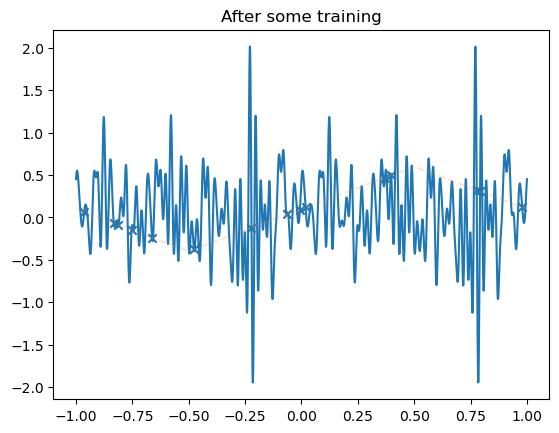

In [52]:
N_steps = 100000

for i, model in enumerate(model_list):
    losses = train(model, 
                   dataset, 
                   N_steps=N_steps, 
                   batch_size=30, 
                   lr=.01, 
                   save_weights_every=1,
                   )
    all_losses[i] += losses
    plot_net(model)

plot_data(dataset)
plt.title('After some training')

plt.show()

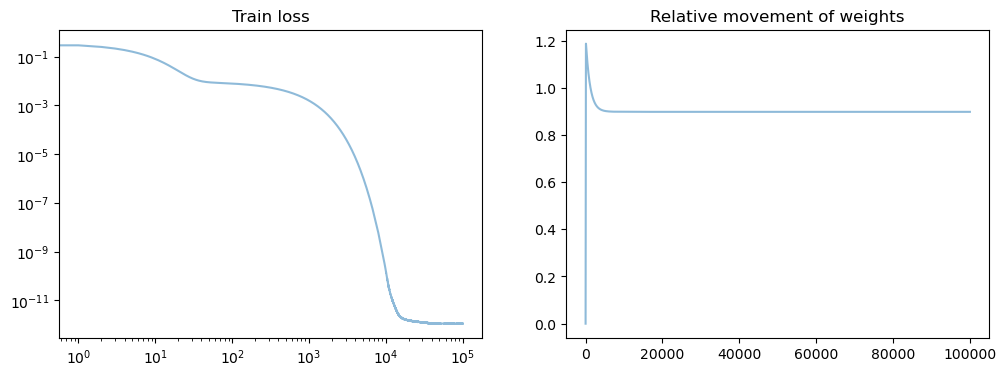

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Train loss')
for losses in all_losses:
    points = np.arange(0, len(losses), 1)  
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=.5)

axs[1].set_title('Relative movement of weights')
for model in model_list:    
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=.5) 

plt.show()

# Lazy training of non-linear models

We now train some neural nets in different regimes and try to see when lazy training occurs. 

**Question** 
How are nets initialized in pytorch?

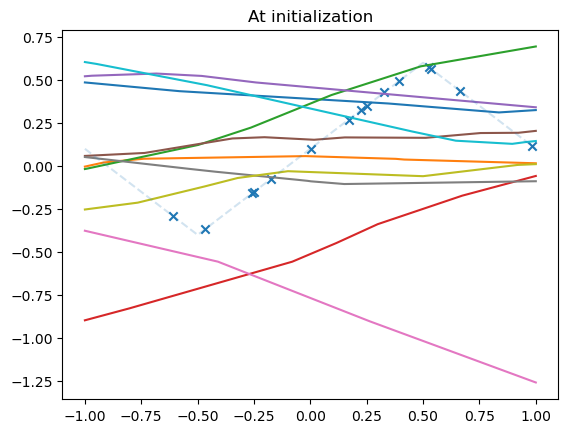

In [12]:
model_list = []
N_models = 10
for _ in range(N_models): 
    model = MLPshallow(hidden_dim=10)
    model_list.append(model)
    plot_net(model)

plot_data(dataset)
plt.title('At initialization')

all_losses = [[] for _ in range(N_models)]
all_weights = []

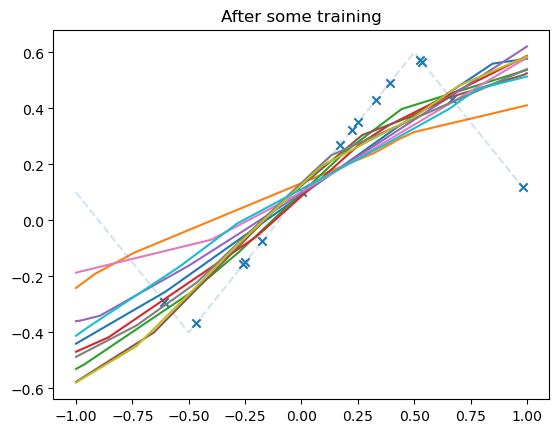

In [13]:
N_steps = 5000

for i, model in enumerate(model_list):
    losses = train(model, 
                   dataset, 
                   N_steps=N_steps, 
                   batch_size=30, 
                   lr=.001, 
                   save_weights_every=1,
                   )
    all_losses[i] += losses
    plot_net(model)

plot_data(dataset)
plt.title('After some training')

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Train loss')
for losses in all_losses:
    points = np.arange(0, len(losses), 1)  
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=.5)

axs[1].set_title('Relative weight movement of last layer')
for model in model_list:    
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=.5) 

plt.show()

## Thin vs. Wide networks

Let us now vary the width of our network. What happens? 

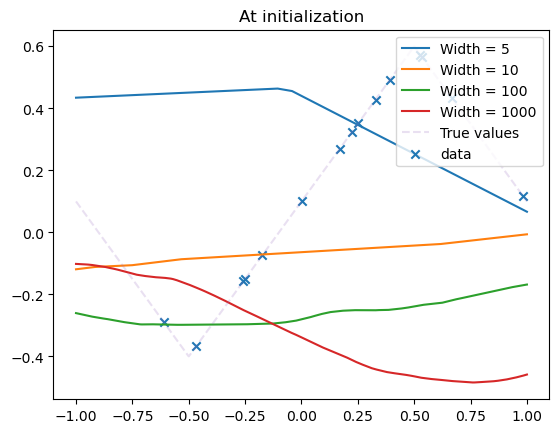

In [20]:
model_list = []

width_list = [5, 10, 100, 1000]

for width in width_list: 
    model = MLPshallow(hidden_dim=width)
    model_list.append(model)
    plot_net(model, label=f'Width = {model.hidden_dim}')

plot_data(dataset)
plt.title('At initialization')
plt.legend()

all_losses = [[] for _ in width_list]
all_weights = []

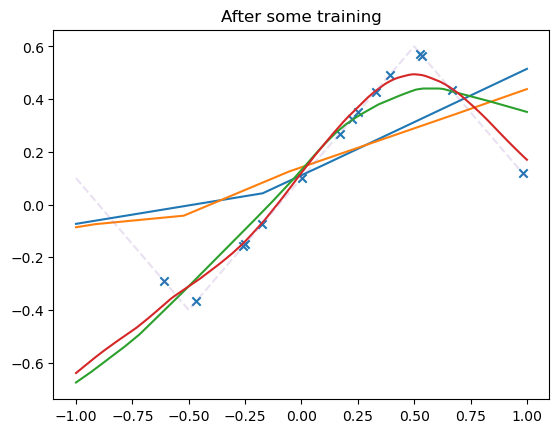

In [21]:
N_steps = 5000

for i, model in enumerate(model_list):
    losses = train(model, 
                   dataset, 
                   N_steps=N_steps, 
                   batch_size=30, 
                   lr=.001, 
                   save_weights_every=1,
                   )
    all_losses[i] += losses
    plot_net(model, label=f'Width = {model.hidden_dim}')

plot_data(dataset)
plt.title('After some training')

plt.show()

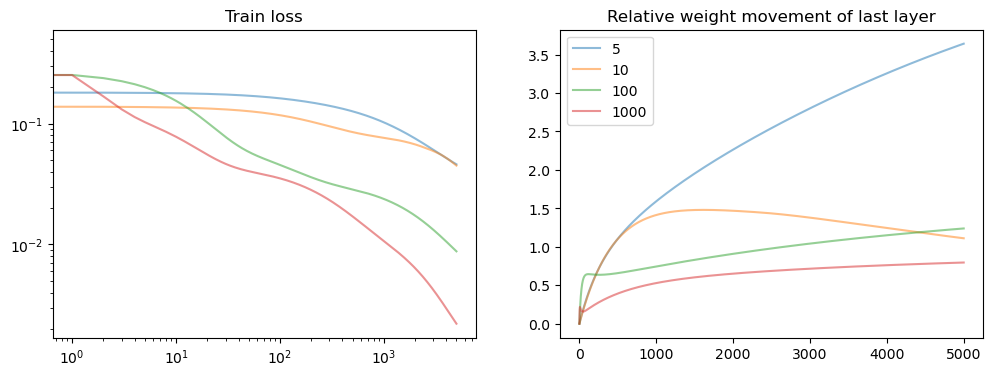

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Train loss')
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)  
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=.5, label=f'{width_list[i]}')

axs[1].set_title('Relative weight movement of last layer')
for model in model_list:    
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=.5, label=f'{model.hidden_dim}') 

plt.legend()
plt.show()

## Bad initialization can you get you out of the Lazy regime


We simulate bad initialization by taking two steps of gradient descent from initialization.

In [ ]:
model_list = []
N_models = 10
for _ in range(N_models): 
    model = MLPshallow(hidden_dim=100)
    model_list.append(model)
    train(model, 
        dataset, 
        N_steps=2, 
        batch_size=30, 
        lr=1, 
        save_weights_every=-1,
        )
    plot_net(model)


plot_data(dataset)
plt.title('At bad initialization')

all_losses = [[] for _ in range(N_models)]
all_weights = []

In [ ]:
N_steps = 1000
xmin = np.min(dataset.inputs.detach().numpy())
xmax = np.max(dataset.inputs.detach().numpy())
plt.xlim(xmin, xmax)
print(xmin, xmax)

for i, model in enumerate(model_list):
    losses = train(model, 
                   dataset, 
                   N_steps=N_steps, 
                   batch_size=30, 
                   lr=.001, 
                   save_weights_every=1,
                   )
    all_losses[i] += losses
    plot_net(model, xmin=xmin, xmax=xmax)

plot_data(dataset)
plt.title('After some training')

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Train loss')
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)  
    losses = np.array(losses)
    axs[0].loglog(points, losses[points], alpha=.5)

axs[1].set_title('Relative weight movement of last layer')
for model in model_list:    
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=.5) 

plt.show()

# Scaling

Now we attempt to enter the lazy regime by scaling the model outputs.

In [23]:
n_points = 10

dataset = Data(n=n_points,
                xmin=-1,
                xmax=1,
                noise_level=0,
                type='middle')

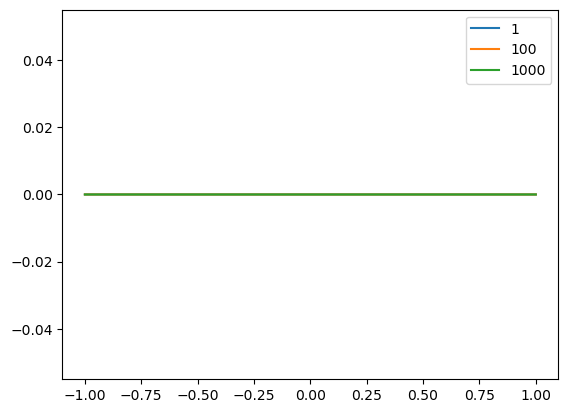

In [24]:
class ScaledModel(MLPdeep):
    """"
        From a base network, creates a scaled copy with 0 initialization. Keeps a frozen copy of a base model. 

        alpha: scaling factor
    """
    def __init__(self, base_model, alpha=1):
        super().__init__(hidden_dim=base_model.hidden_dim)
        
        self.alpha = alpha
        self.load_state_dict(base_model.state_dict())

        self.base_model = [base_model] # trick to hide from the other parameters dictionary. Probably not the proper way to do this...

    def forward(self, x):
        """
            Scales the output and subtracts the initial function 
        """
        with torch.no_grad():
            base = self.base_model[0].forward(x).detach()
        return self.alpha * (super().forward(x) - base)

base_model = MLPdeep(hidden_dim=8)

alphas = [1, 100, 1000]#, 2000, 10000]
model_list = []

for alpha in alphas: 
    new_model = ScaledModel(base_model, alpha=alpha)
    new_model.load_state_dict(base_model.state_dict())
    model_list.append(new_model)

    plot_net(new_model, label=f'{alpha}')

all_losses = [[] for _ in range(len(model_list))]

plt.legend()
plt.show()

In [ ]:
train(model_list[2], 
    dataset, 
    N_steps=10000,
    batch_size=n_points, 
    lr=.1 / alphas[2]**2, 
    save_weights_every=1,
    )

plot_data(dataset)
plt.legend()
plt.title('After some training')


for i, model in enumerate(model_list):
    plot_net(model, xmin=xmin, xmax=xmax, label=f'alpha = {alphas[i]}')

-1 1


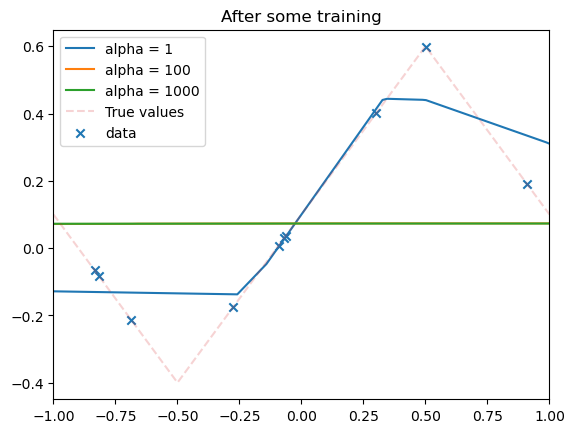

In [26]:
N_steps = 10000
xmin = -1 #np.min(dataset.inputs.detach().numpy())
xmax = 1 #np.max(dataset.inputs.detach().numpy())
plt.xlim(xmin, xmax)
print(xmin, xmax)

for i, model in enumerate(model_list):
    losses = train(model, 
                   dataset, 
                   N_steps=N_steps,
                   batch_size=n_points, 
                   lr=.01 / alphas[i]**2 , 
                   save_weights_every=1,
                   )
    all_losses[i] += losses 
    plot_net(model, xmin=xmin, xmax=xmax, label=f'alpha = {alphas[i]}')

plot_data(dataset)
plt.legend()
plt.title('After some training')

plt.show()

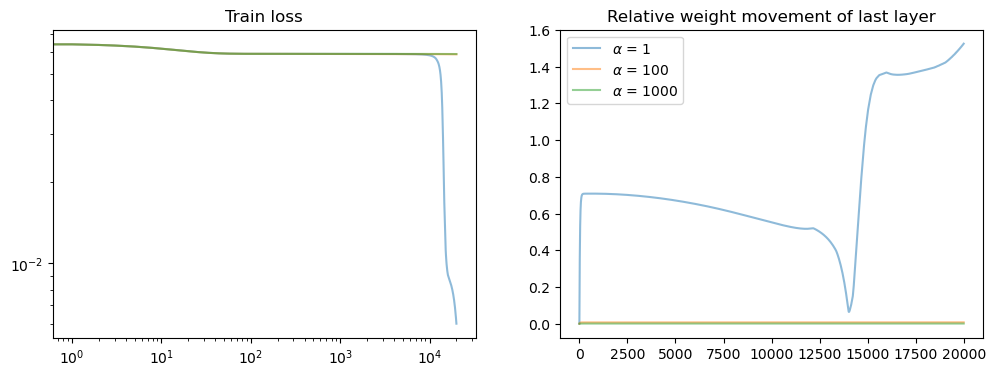

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Train loss')
for i, losses in enumerate(all_losses):
    points = np.arange(0, len(losses), 1)  
    losses = np.array(losses) # / alphas[i] ** 2
    axs[0].loglog(points, losses[points], alpha=.5, label=f'{alphas[i]}')

axs[1].set_title('Relative weight movement of last layer')
for i, model in enumerate(model_list):    
    all_weights1 = np.array(model.weight_history)
    weight_evol = np.linalg.norm(all_weights1 - all_weights1[0], axis=1) / np.linalg.norm(all_weights1[0])

    axs[1].plot(weight_evol, alpha=.5, label=rf'$\alpha$ = {alphas[i]}')

plt.legend()
plt.show()

## 5 - The effect of scaling on a 1D model 

**Question** Explain the piece of code below.

see blog post



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w_0 = 1.5

def f(x, w): 
    return w * x /2  +  np.log(1 + w**2) * x / 5  + .1 * np.sin(np.exp(2*w))#np.exp(0.1*w))

def h(x, w, w_0=.4): 
    return f(x, w) * (w - w_0)

def linh(x, w, w_0=.4):
    return  f(x, w_0) * (w - w_0)

xys = [(1.5, 3)]

def l(w, alpha): 
    return np.sum([(alpha * h(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha ** 2

def linl(w, alpha):
    return np.sum([(alpha * linh(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha ** 2

alphas = [1, 5, 10, 50,  100, 1000, 2000, 10000]

ws = np.linspace(-1, 1, 100)
plt.title('h(2; w)')
plt.plot(ws, [h(2, w, w_0=w_0) for w in ws])
plt.show()

for alpha in alphas:
    delta = 2 / alpha ** (3/4)
    ws = np.linspace(w_0 - delta, w_0 + delta, 5000)
    plt.title(f'Loss landscape of scaled model: alpha = {alpha}')
    plt.plot(ws, [l(w, alpha) for w in ws], label='Loss of scaled model')
    plt.plot(ws, [linl(w, alpha) for w in ws], label='Loss of scaled linearized model')
    plt.grid(alpha=.2)
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w_0 = 1.5

def f(x, w): 
    return w * x /2  +  np.log(1 + w**2) * x / 5  + .1 * np.sin(np.exp(2*w))

def h(x, w, w_0=.4): 
    return f(x, w) * (w - w_0)

def linh(x, w, w_0=.4):
    return  f(x, w_0) * (w - w_0)

xys = [(1.5, 3)]

def l(w, alpha): 
    return np.sum([(alpha * h(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha ** 2

def linl(w, alpha):
    return np.sum([(alpha * linh(x, w, w_0=w_0) - y) ** 2 / 2 for x, y in xys]) / alpha ** 2

alphas = [1, 5, 10, 50,  100, 1000, 2000, 10000]

for alpha in alphas:
    delta = 2 / alpha ** (3/4)
    ws = np.linspace(w_0 - delta, w_0 + delta, 5000)
    plt.title(f'??: alpha = {alpha}')
    plt.plot(ws, [l(w, alpha) for w in ws], label='??')
    plt.plot(ws, [linl(w, alpha) for w in ws], label='??')
    plt.grid(alpha=.2)
    plt.legend()
    plt.show()

## Pieces

In [ ]:
mlp = model_list[0]

for name, param in mlp.named_parameters(): 
    print(name)
    print(param.shape)
    print(np.linalg.norm((param.detach().numpy())))

In [ ]:
a = np.arange(10,30)
shifted_a = np.zeros(20)
print(shifted_a)
shifted_a[1:] = a[:-1]
print(shifted_a)
print(a)

evol = (a - shifted_a)[1:] / a[1:]
print(evol)

In [ ]:
plt.title('Difference in succesive weights')
for model in model_list:    
    all_weights1 = np.array(model.weight_history)
    shifted_weights = np.zeros(all_weights1.shape)
    shifted_weights[1:, :] = all_weights1[:-1, :]
    weight_evol = (np.linalg.norm((all_weights1 - shifted_weights)[1:], axis=1) 
                   / np.linalg.norm(all_weights1[1:], axis=1))

    plt.plot(weight_evol, alpha=.5) 


plt.show()

You can use the following code snippet to save your network.

In [ ]:
# mlp = MLPdeep() # MLPshallow()
# PATH = f'./{dataset.type}_{mlp.net_type}.pth'
# torch.save(mlp.state_dict(), PATH)

# net = MLPdeep() # MLPshallow()
# net.load_state_dict(torch.load(PATH))

1.2872850938240181


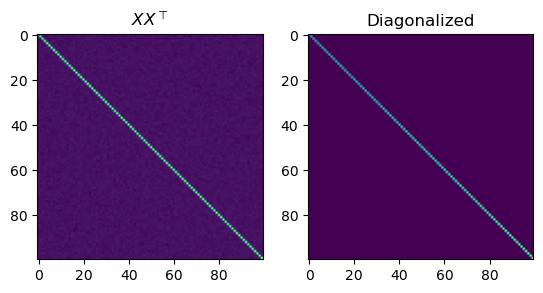

100


In [249]:
p = 100
n = 5000

X = np.random.normal(size=(p, n))  / np.sqrt(n) 
Y = np.random.normal(size=(n, 1))

XXt = X @ X.transpose()
XY = X @ Y

fig, axs = plt.subplots(1, 2)

axs[0].set_title(r'$X X^\top $')
axs[0].imshow(XXt)

eigvals, P = np.linalg.eigh(XXt)
print(max(eigvals))

axs[1].set_title('Diagonalized')
axs[1].imshow(P.transpose() @ XXt @ P)
plt.show()

print(np.linalg.matrix_rank(X))

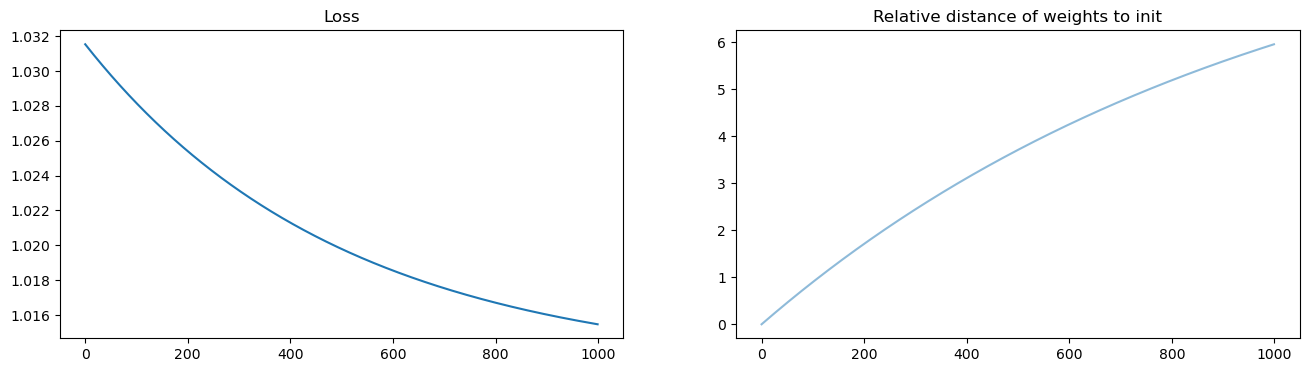

In [250]:
T = 1000
eta = 0.001

ws = np.zeros((T, p, 1))
w = np.random.normal(size=(p, 1))  / np.sqrt(p)

losses = []
for t in range(T):
    w = w - eta * XXt @ w + eta * XY
    ws[t] = w

    losses.append(np.linalg.norm(X.transpose() @ w  - Y)**2 / n )

ws = ws.squeeze(axis=2)
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].set_title('Loss')
axs[0].plot(losses) 


axs[1].set_title('Relative distance of weights to init')
weight_evol = np.linalg.norm(ws - ws[0, :], axis=1) / np.linalg.norm(ws[0, :])
axs[1].plot(weight_evol, alpha=.5) 
 

plt.show()

# In the right basis, most coordinates of w dont move

w only moves in a low dimensional subspace: the image of X

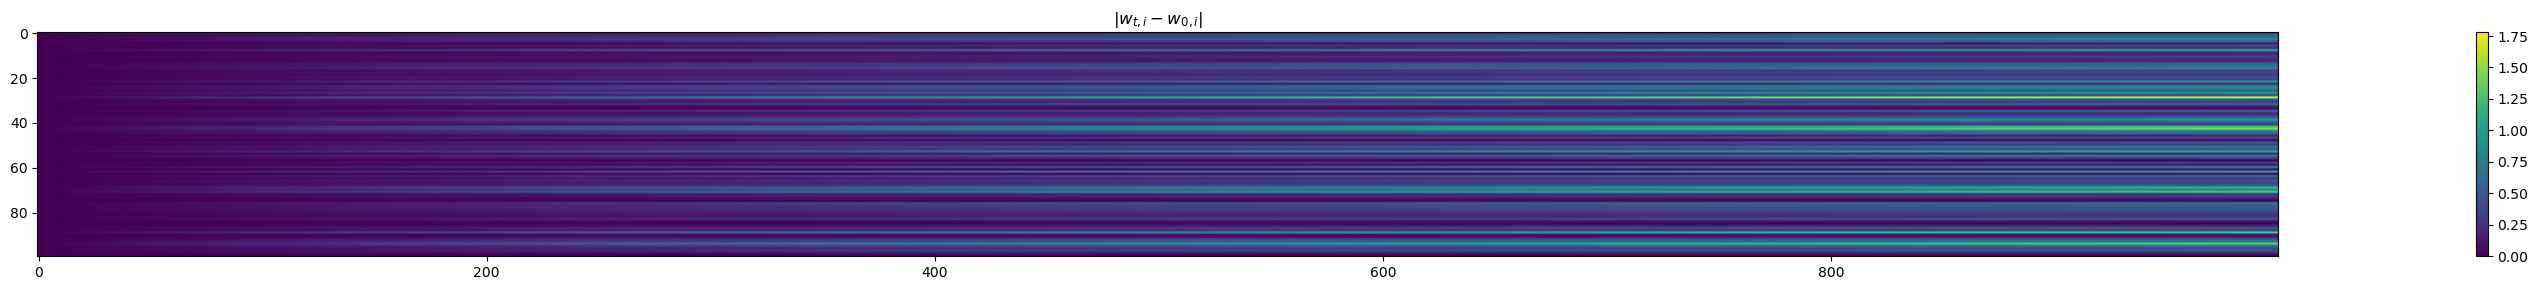

In [251]:
fig, ax = plt.subplots(figsize=(40, 3))

plt.title(r'$|w_{t, i} - w_{0, i}|$')
ws_in_base = ws @ P

a = ax.imshow(np.abs((ws_in_base - ws_in_base[0]).transpose()))
fig.colorbar(a)
plt.tight_layout()
plt.show()

Bias complexity tradeoff

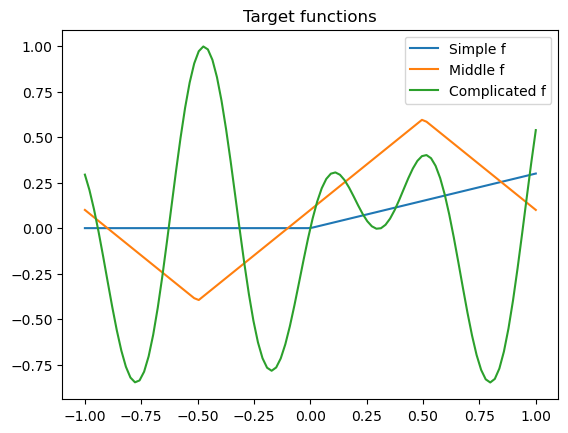

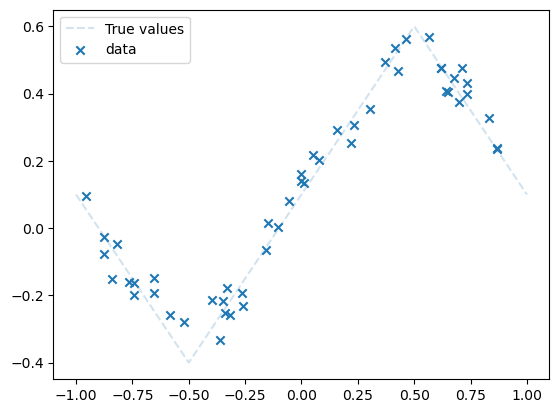

In [284]:
xs = np.linspace(-1, 1, 100)
plt.plot(xs, simple_f(xs), label='Simple f')
plt.plot(xs, middle_f(xs), label='Middle f')
plt.plot(xs, complex_f(xs), label='Complicated f')
plt.title('Target functions')
plt.legend()
plt.show()

npoints = 50

dataset = Data(n=npoints,
                xmin=-1,
                xmax=1,
                noise_level=0.05,
                type='middle')

plot_data(dataset)
plt.legend()
plt.show()

In [285]:
class LinSin(nn.Module): 
    """
        A linear model with sinusoidal features. Assumes feature_dim is even.
    """
    def __init__(self, feature_dim): 
        super().__init__()
        self.feature_dim = feature_dim
        self.lout = nn.Linear(self.feature_dim, 1)

        self.weight_history = []

    def phi(self, x):
        """
            Computes $sin(2\pi k x), cos(2\pi k x) $ for k in $[feature_dim / 2]$
        """
        r = .2 * np.pi * torch.arange(int(self.feature_dim / 2)) * x
        return torch.concatenate([torch.sin(r), torch.cos(r)], axis=1)

    def save_weights(self): 
        with torch.no_grad():
            l = list(self.parameters())
            self.weight_history.append(np.copy(l[-1].numpy()))

    def forward(self, x): 
        return self.lout(self.phi(x))

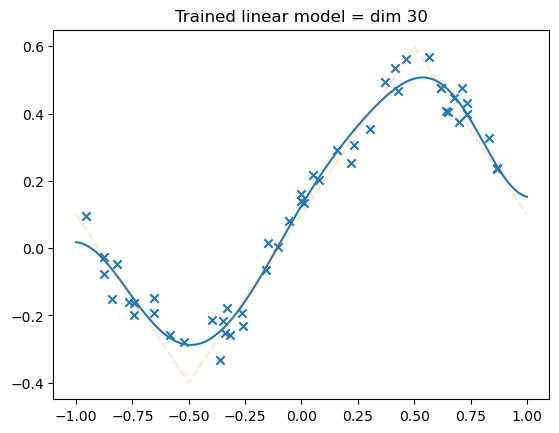

tensor(0.0026)


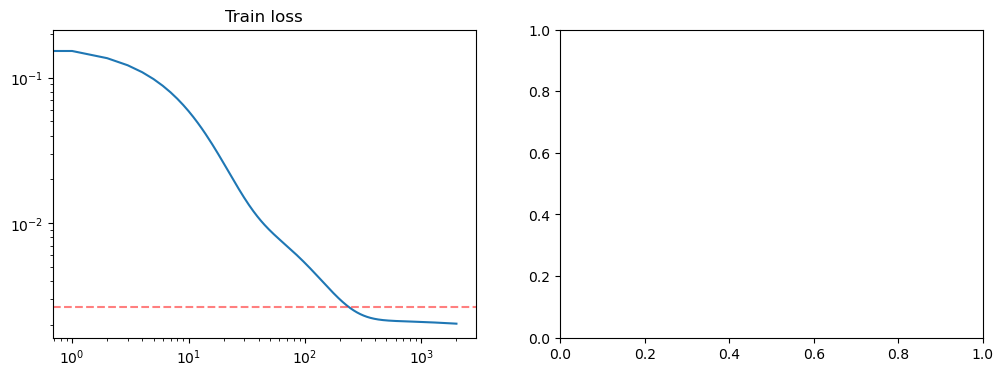

In [313]:
model = LinSin(feature_dim=30)
losses = train(model, 
                dataset, 
                N_steps=2000, 
                batch_size=npoints, 
                lr=.01, 
                save_weights_every=-1,
                )

plot_net(model)
plot_data(dataset)
plt.title('Trained linear model = dim 30')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].loglog(losses)
axs[0].set_title('Train loss')
true_risk = dataset.risk(model)
print(true_risk)
axs[0].axhline(true_risk, color='red', alpha=.5, linestyle='--')


plt.show()

In [293]:
# train_losses = []
# var_train = []
# risks = []
dimensions = np.array(list(range(150, 200, 2)))# + list(range(100, 300, 2)))
for dim in dimensions:
    losses = []
    local_risks = []
    for _ in range(10):
        model = LinSin(feature_dim=dim)
        losses.append(train(model, 
                        dataset, 
                        N_steps=1000, 
                        batch_size=100, 
                        lr=.1, 
                        save_weights_every=-1,
                        )[-1])
        local_risks.append(dataset.risk(model).detach())
    train_losses.append(np.mean(losses))
    var_train.append(np.var(losses))
    risks.append(np.mean(local_risks))
    


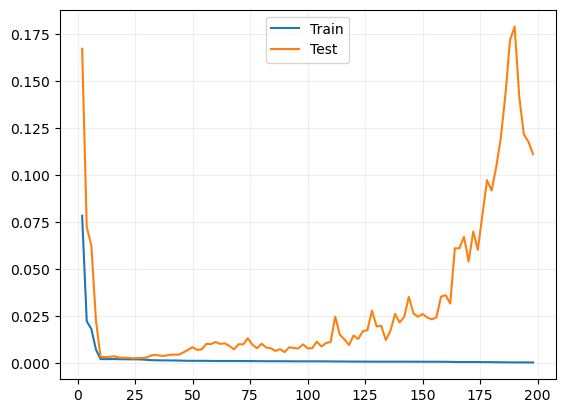

In [297]:
plt.grid(alpha=.2)

plt.plot(np.arange(2, 200, 2),train_losses, label='Train')
plt.plot(np.arange(2, 200, 2), risks, label='Test')
plt.legend()